In [ ]:
#!pip install pandas numpy matplotlib seaborn scikit-learn

In [17]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
# Load the datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# print("Train Data Shape:", train_df.shape)
# display(train_df.head())

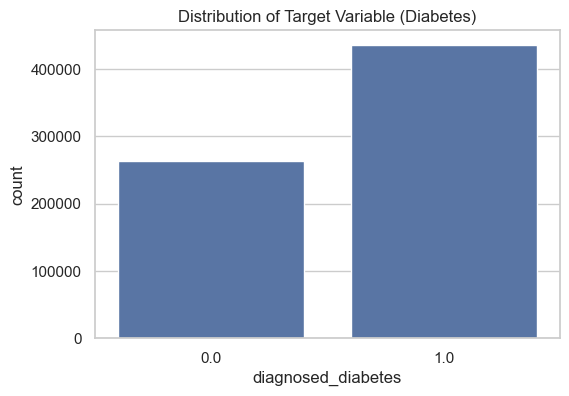

In [ ]:
# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosed_diabetes', data=train_df)
plt.title('Distribution of Target Variable (Diabetes)')
plt.show()

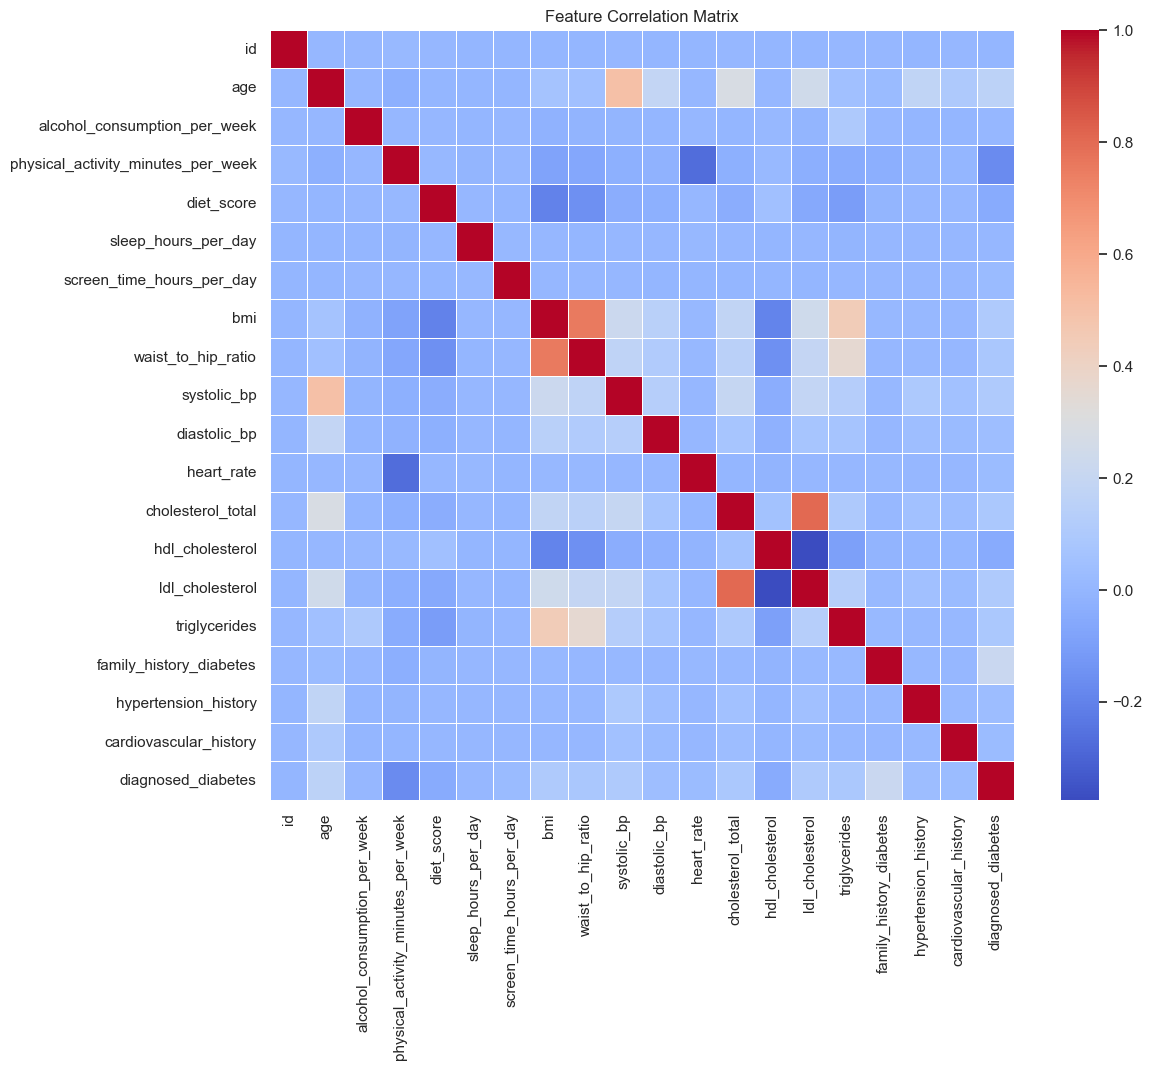

In [ ]:
plt.figure(figsize=(12, 10))

# Select only numeric columns for correlation
numeric_df = train_df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

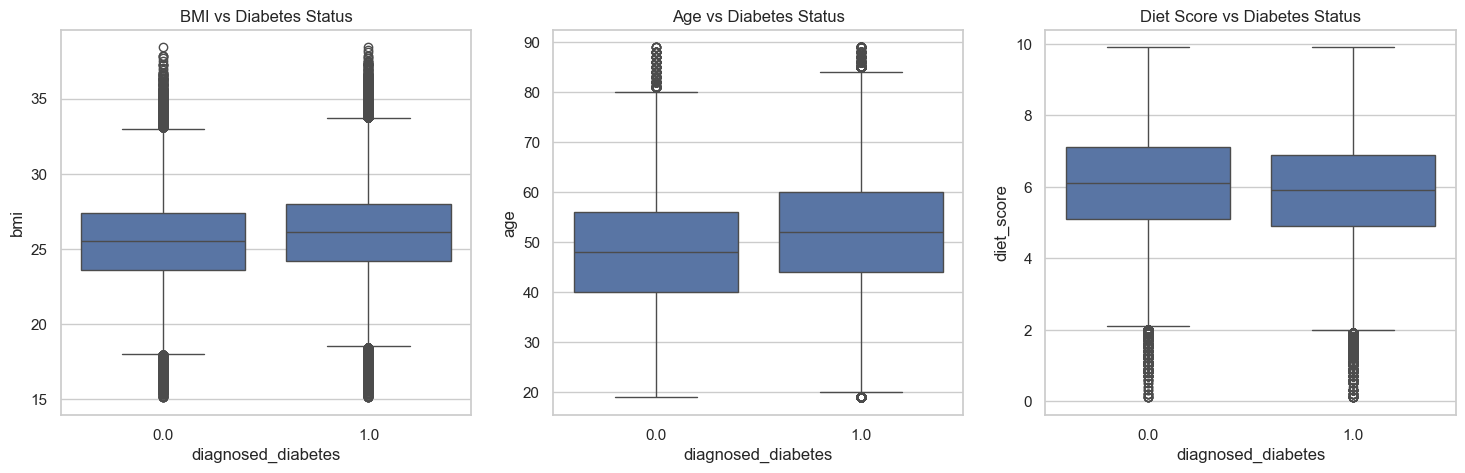

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='diagnosed_diabetes', y='bmi', data=train_df, ax=axes[0])
axes[0].set_title('BMI vs Diabetes Status')

sns.boxplot(x='diagnosed_diabetes', y='age', data=train_df, ax=axes[1])
axes[1].set_title('Age vs Diabetes Status')

sns.boxplot(x='diagnosed_diabetes', y='diet_score', data=train_df, ax=axes[2])
axes[2].set_title('Diet Score vs Diabetes Status')

plt.show()

In [18]:
# 1. Prepare Data
X = train_df.drop(['diagnosed_diabetes', 'id'], axis=1)
y = train_df['diagnosed_diabetes']

# 2. Preprocessing
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 3. Model Definition
# n_estimators=200 helps stabilize probability estimates
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# 4. Split for Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Train
clf.fit(X_train, y_train)
print("Model Trained.")

Model Trained.


In [19]:
# 1. Retrain on all available data for best performance
clf.fit(X, y)

# 2. Prepare Test Set
X_test = test_df.drop(['id'], axis=1)

# 3. Predict Probabilities
# We take the second column [:, 1] which corresponds to the probability of label '1'
test_probs = clf.predict_proba(X_test)[:, 1]

# 4. Create Submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'diagnosed_diabetes': test_probs
})

# 5. Save
submission.to_csv('submission.csv', index=False)

print("Submission file created.")
display(submission.head())

Submission file created.


,id,diagnosed_diabetes
0,700000,0.533630
1,700001,0.575296
2,700002,0.631632
3,700003,0.593639
4,700004,0.718611
